# Determine BATCH II Scan Errors

#### Updated: April 24, 2023 by Ashley Ferreira

#### Introduction (to the issues we attempt to quantify)
There are two potentail issues with the scanning we are trying to isolate and get an idea for how prevelant they are:
1. Images are cropped too soon (causes aspect ratio to be less wide than expected)
2. Images are out of phase (can see two sets of metadata on either side of ionogram instead of middle)

Issue 1 is the easiest to detect by just reading in the pixel scale and calculating the aspect ratio, wheras for Issue 2 we need to use an optical character regonition program to estimate the number of digits in the metadata. Both of these cause us to not be able to see the ionogram trace correctly. Images like first and last ones of most subdirs are supposed to be off and not have the normal ionogram aspect ratios so it is normal to expect a certain small rate of these images.

#### Setup 
You will likely need to pip install tensorflow and keras_ocr as they do not come by default with anaconda, uncomment the cells below to do this if needed. Then run the cells to import the libraries adn set some of the default parameters.

In [ ]:
#! pip install tensorflow --user

In [ ]:
#! pip install keras_ocr --user

In [1]:
# imports
import cv2
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
#from numba import jit, cuda

# replace this with your own library path for --user pip installs
sys.path.append('C:/Users/aferreira/AppData/Roaming/Python/Python38/Scripts')
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\aferreira\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\aferreira\.keras-ocr\crnn_kurapan.h5


In [6]:
# set paths
batchDir = 'L:/DATA/Alouette_I/BATCH_II_raw/'
save_dir = 'U:/Downloads/' 
outFile = save_dir + 'notebook19_outputs_v8_FalseJustDigits.csv'

# set default saving settings
append2outFile = True
saveImages = False

#### Inititalize functions
The main processing for this code uses two functions, read_all_rolls() which loops over all the batch 2 raw data ionogram images and saves the outputs from read_image() to a CSV file. This second function, read_image() reads in one image a time, whos path is passed it it by read_all_rolls(), and outputs the height and width along with the estimated digit count of the metadata. 

In [3]:
def read_image(image_path, plotting=False, just_digits=True):
    '''
    This function reads in one image a time and outputs the height 
    and width along with the estimated digit count of the metadata.

    Parameters:

        image_path (str): path to the image

        plotting (bool, optional): True for a verbose display mode to
                                   illustrate the analysis in detail, 
                                   False otherwise

        just_digits (bool, optional): if True only count characters that are 
                                      integers, False to count any characters

    Returns:

        digit_count (int): estimated number of integers in the ionogram
                          metadata (right now, only looks for numbers along
                          bottom 20% of the image, usually only 15 expected)
                          ~~~~ done for cropped image ~~~~
    
        height (int): number of pixels along y-axis of original image
        
        width (int): number of pixels along x-axis of origional image

        says_isis (bool): True if 'isis' independant of capitalization is 
                          present within the detected text, False otherwise
                          ~~~~ done for origional image ~~~~
    '''

    try: 

        # read in image using keras_ocr
        image = keras_ocr.tools.read(image_path) 

        # extract height and width of image in pixels 
        height, width = image.shape[0], image.shape[1]

        # cut image to just include bottom 20% of pixels
        cropped_height = height-height//5
        cropped_image = [image[cropped_height:height,:]]

        # create predictions for location and value of characters
        # on the cropped image, will output (word, box) tuples
        prediction = pipeline.recognize([image])[0]

        if plotting == True:
            # display original image to make sure it is alright
            plt.imshow(image)
            plt.show()

            # display the cropped image
            plt.imshow(cropped_image[0])
            plt.show()

        # if no characters are found move on
        if prediction == [[]]:
            digit_count = 0

        # if characters are found look at the predictions
        else:
            if plotting == True:
                # plot the predictied box and tuples
                keras_ocr.tools.drawAnnotations(image=image, predictions=prediction)
                plt.show()

            # check how many are numbers since letters are often picked up from noise 
            # (sometimes something like a '0' maps to an 'o', but we only expect digits in metadata)

            # loop over predicted (word, box) tuples and count number of digit characters
            digit_count = 0
            says_isis = False
            for p in prediction:

                # select word and box part of the tuple
                value, box = p[0], p[1]

                # check for 'isis' of any capitalization in image
                # (can do the text detection process more efficiently)
                if 'isis' in value.lower():
                    says_isis = True
                    print('found potential ISIS text')
                
                # if word is composed of just integers then 
                # count how many and incriment digit_count
                if just_digits == False or (just_digits == True and value.isdigit()):

                    # check that box is within the cropped height
                    in_bounds = True
                    for b in box:
                        if b[1] < cropped_height:
                            in_bounds = False
                            break
                            
                    if in_bounds:
                        digit_count += len(value)

        print('digits count:', digit_count)

    except:
        print('ERR')
        digit_count, height, width, says_isis = 'ERR', 'ERR', 'ERR', 'ERR'

    return digit_count, height, width, says_isis

In [4]:
def read_all_rolls(outFile=outFile, append2outFile=True, batchDir=batchDir, saveImages=saveImages, plotting=False):
   '''
   This function loops over all images nested within batchDir
   and saves the outputs from read_image() to a CSV file.

   Parameters:

      outFile (str, optional): path to CSV file where results from this 
                               function can be stored 

      append2outFile (bool, optional): if True will append to data in outFile 
                                       (if any exists), otherwise overwrites

      batchDir (str, optional): path to directory of entire batch 
                                of ionogram scan images to analyze

      saveImages (bool, optional): True to save all images with irregular
                                    aspect ratios for visual inspection, 
                                    False otherwise

      plotting (bool, optional): True if programs should create and show plots
                                 while running, Flase otherwise 

   Returns:

      None

   '''
   # check if there is already data in the output file 
   if os.path.exists(outFile) and os.path.getsize(outFile)!=0:
      found = False
      header = False 

      df = pd.read_csv(outFile)
      last_entry = batchDir + df['roll'].iloc[-1] + '/' + df['subdir'].iloc[-1] + '/' + df['image'].iloc[-1]
      del df 

   else: 
      found = True
      header = True
      last_entry = ''

   # initialize lists to save values to in loop
   rolls, subdirs, images = [], [], []
   heights, widths, digit_counts = [], [], []
   says_isis_lst = []

   images_since_save = 0
   
   # loop over all rolls in the batch 2 raw data directory
   raw_contents = os.listdir(batchDir)
   for roll in raw_contents:

      # loop over all subdirectories within the roll
      roll_contents = os.listdir(batchDir + roll) 
      for subdir in roll_contents:
         
         # loop over all images in the subdirectory
         subdir_contents = os.listdir(batchDir + roll + '/' + subdir) 
         for image in subdir_contents:

            # save full path of image
            image_path = batchDir + roll + '/' + subdir + '/' + image

            # skip over image if already analyzed in CSV
            if found == False and last_entry == image_path:
               found = True

            if found == True:
               images_since_save += 1

               # make sure path exits
               #pathExist = os.path.exists(image_path)
               #if pathExist:

               # save id of image
               rolls.append(roll)
               subdirs.append(subdir)
               images.append(image)

               # send to read_image to get aspect ratio, digit count, and isis text
               num_of_digits, h, w, says_isis = read_image(image_path, plotting=plotting, just_digits=False)

               # aspect ratio could also be read in like
               #im = cv2.imread(image_path, 0)
               #h, w = im.shape

               # save values
               digit_counts.append(num_of_digits)
               heights.append(h)
               widths.append(w)
               says_isis_lst.append(says_isis)
               
               # this is not used anymore but was helpful  
               # in exploring the acceptable aspect ratios
               if saveImages == True:
                  if (w/h < 1.2) or (w/h > 3):
                     save_name = save_dir + 'off_aspect_ratios/' + roll + '_' + subdir + '_' + image
                     im = cv2.imread(image_path, 0)
                     cv2.imwrite(save_name, im)   
                     print('aspect ratio is off, saved image to:', save_name)               

               # save to csv each 100 images
               if images_since_save == 100:
                  images_since_save = 0

                  # initialize dataframe and save results to csv
                  # (redoing this each interation to not loose information)
                  df_mapping_results = pd.DataFrame()

                  df_mapping_results['roll'] = rolls
                  df_mapping_results['subdir'] = subdirs
                  df_mapping_results['image'] = images
                  df_mapping_results['digit_count'] = digit_counts
                  df_mapping_results['height'] = heights
                  df_mapping_results['width'] = widths
                  df_mapping_results['says_isis'] = says_isis_lst

                  # mode = 'a' means it will append to existing data within the file
                  if append2outFile == True:
                     mode = 'a' 

                     # wipe lists now that they have been saved
                     rolls, subdirs, images = [], [], []
                     heights, widths, digit_counts = [], [], []
                     says_isis_lst = []
                     
                  else: 
                     # this overwrites existing file
                     mode = 'w'
                     header = True

                  df_mapping_results.to_csv(outFile, mode=mode, index=False, header=header)
                  del df_mapping_results

Why are digits counted in only only bottom 20% of pixels?
- The metadata we are interested in is expected to be at the bottom of the image, below the ionogram graph
- Including the data from the ionogram graph makes the keras_ocr functions more likely to predict random words from the noise, so its best to lower the chances of this by cropping the image
- Some images are upsidedown or for another reason will have their metadata cut off due to the crop but it is okay for us to underestimate, and this is preffered when compared to overestimating
- There are some images which contain just long sections of metadata and these are not out of phase but would contribute to an overestimation and so cropping bottom 20% opposed to bottom 200 pixels allows us to filter out the characters on those images from view


^ In general this is also much more efficient since 80% less pixels need to be processed but now that we are interested in detecting ISIS text in the entire image we feed 100% of the pixels to the predictor so it really no longer helps much with processing time.

Possible improvements to these functions:
- improve the ocr detection and regonition parts
- make code more efficient, not focused too much with L drive and keras OCR being main limitting factors
- use consistent mehtod of naming variables

#### A note on efficiency improvements

Fruitful speed up efforts (mostly implimented in notebook 20):
- Significant improvement with image load times through VDI compared to local+VPN
- Using del to clear dataframes that are no longer in use and forced garbage collection
- Writing to file in batches
- Multithreading (allows more CPU and memory maximization on local and VDI)

Not fruitful efforts:
- Batching keras_ocr inputs (time seems to be relatively proportional to inputted images, may just hold unessisary space in memory - not completly solved but wasn't an easy fix)
- GPU acceleration with Numba/jit (has some issues with keras_ocr compatibility, I tried a few different setups, may need to install tfgpu. Note that local GPU does not seem to be CUDA compatible but I imagine VDI one may be but sometimes is just missing??)

Ideas not yet tried:
- Load images in batches
- Downscale
- JPG convert
- More lightweight packages like EasyOCR, tessar-ocr
- Just use detector and not regonizer
- C++/GPU wrapper 
- Initial perprocessing of subdir: saving to downscaled jpeg in batches then feeding to keras_ocr + potential dim reduction


#### Running the functions
Below, I run the read_all_rolls() function for the batch 2 raw data directory and it saves the results as it processes. 

In [ ]:
# run function for batch 2 results
read_all_rolls(plotting = False) 

#### Analyzing Results

rows filtered out due to errors: 2


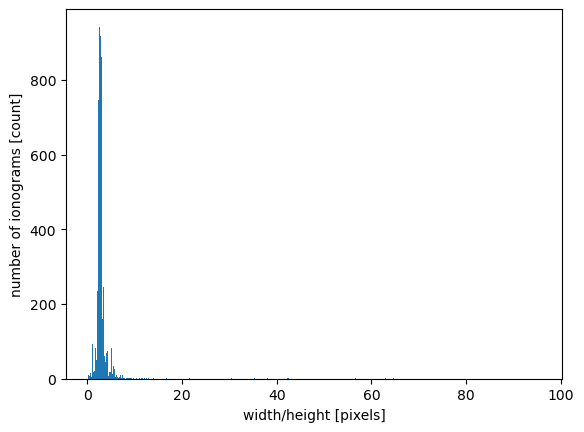

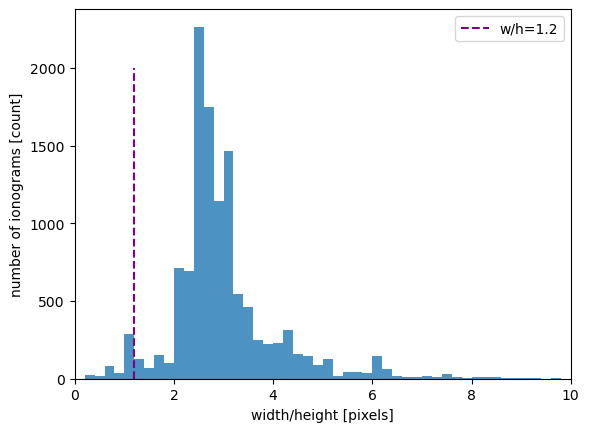

3.72 % of ionograms have w/h < 1.2


In [34]:
# read in csv file
df_results = pd.read_csv(outFile)
total_len = len(df_results)

# filter out error rows
df_results = df_results.loc[df_results['digit_count'] != 'ERR']
filtered_down_len = len(df_results)
print('rows filtered out due to errors:', total_len - filtered_down_len)

# calculate aspect ratios
w = df_results['width'].astype(int)
h = df_results['height'].astype(int)
aspect_ratios = w/h

# histogram of aspect ratios
plt.hist(aspect_ratios, bins='auto')
plt.xlabel('width/height [pixels]')
plt.ylabel('number of ionograms [count]')
plt.show()

# make histogram data more clear
plt.hist(aspect_ratios, bins=np.arange(0.0, 10.0, 0.20), alpha=0.8)
plt.xlabel('width/height [pixels]')
plt.ylabel('number of ionograms [count]')
plt.xlim(0,10)
#plt.yscale('log')

# add vertical line at w/h = 1.2
plt.vlines(x=1.2, ymin=0, ymax=2000, colors='purple', linestyles='--', label='w/h=1.2')
plt.legend()
plt.show()

# percentage of w/h < 1.2
n = len([ x for x in aspect_ratios if x < 1.2 ])
print(round(100*n/filtered_down_len,2), '% of ionograms have w/h < 1.2')

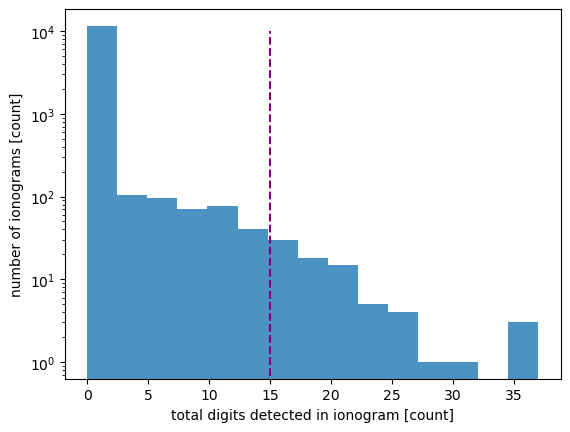

0.56 % of ionograms have digit_count > 15


In [39]:
# log historgam of metadata readings
digit_counts = df_results['digit_count'].astype(int)

plt.hist(digit_counts, bins='auto', alpha=0.8)
plt.xlabel('total digits detected in ionogram [count]')
plt.ylabel('number of ionograms [count]')
plt.yscale('log')
plt.vlines(x=15, ymin=0, ymax=pow(10,4), colors='purple', linestyles='--')
plt.show()

# percentage with digit_count > 15
n = len([ x for x in digit_counts if x > 15 ])
print(round(100*n/filtered_down_len,2), '% of ionograms have digit_count > 15')

In [ ]:
# percent of ISIS text on images


# how many unique ISIS subdirectories


# how much as percentage of the total


In [ ]:
############## DEPRECIATED ################
#### faster but cannot do isis text detection ###
def read_image_noISIS(image_path, plotting=False):
    '''
    This function reads in one image a time and outputs the height 
    and width along with the estimated digit count of the metadata.

    Parameters:

        image_path (str): path to the image

        plotting (bool, optional): True for a verbose display mode to
                                   illustrate the analysis in detail, 
                                   False otherwise

    Returns:

        char_count (int): estimated number of characters in the ionogram
                          metadata (right now, only looks for numbers along
                          bottom 20% of the image, usually only 15 expected)
                          ~~~~ done for cropped image ~~~~
    
        height (int): number of pixels along y-axis of original image
        
        width (int): number of pixels along x-axis of origional image

    '''

    try:

        # read in image using keras_ocr
        image = keras_ocr.tools.read(image_path) 

        # extract height and width of image in pixels 
        height, width = image.shape[0], image.shape[1]

        # cut image to just include bottom 20% of pixels
        cropped_image = [image[height-height//5:height,:]]

        # create predictions for location and value of characters
        # on the cropped image, will output (word, box) tuples
        prediction = pipeline.recognize(cropped_image)[0]

        if plotting == True:
            # display original image to make sure it is alright
            plt.imshow(image)
            plt.show()

            # display the cropped image
            plt.imshow(cropped_image[0])
            plt.show()

        # if no characters are found move on
        if prediction == [[]]:
            char_count = 0

        # if characters are found look at the predictions
        else:
            if plotting == True:
                # plot the predictied box and tuples
                keras_ocr.tools.drawAnnotations(image=cropped_image[0], predictions=prediction)
                plt.show()

            # check how many are numbers since letters are often picked up from noise 
            # (sometimes something like a '0' maps to an 'o', but we only expect digits in metadata)

            # loop over predicted (word, box) tuples and count number of digit characters
            char_count = 0
            for p in prediction:

                # select just the word part of the tuple
                value = p[0]
                
                # if word is composed of just integers then 
                # count how many and incriment char_count
                if value.isdigit():
                    char_count += len(value)

    except:
        print('ERR')
        char_count, height, width = 'ERR', 'ERR', 'ERR'

    return char_count, height, width